# Trabajo Practico
## Desarrollo de Modelos Analíticos (Machine Learning) K5051 -2024
### Grupo 3
#### Nigliazzo, Matias Ezequiel
#### Choque Llanqui, Edson Gustavo
#### Sanchez, Tomas Agustin

#### Lectura de archivo de datos

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('future.no_silent_downcasting', True)

# Leer el archivo data.csv
data=pd.read_csv('data/data.csv',sep='|',dtype={'client_id':int,'Target':int},skipfooter = 1, engine='python')
data.shape

(238615, 77)

In [30]:
print("Cantidad de registros de cada mes: ")
data.Month.value_counts(sort=True,ascending=True)

Cantidad de registros de cada mes: 


Month
2018-10-01    26501
2018-09-01    26501
2018-12-01    26501
2018-11-01    26501
2018-08-01    26502
2019-01-01    26503
2019-02-01    26512
2019-04-01    26547
2019-03-01    26547
Name: count, dtype: int64

In [31]:
print("Cantidad de clientes: ",len(data.client_id.unique()))

Cantidad de clientes:  26560


#### Universo

In [32]:
data_9m = pd.DataFrame(data.client_id.value_counts().reset_index(name='q_meses')).query('q_meses >= 9')
data_9m

,client_id,q_meses
0,5856970,9
1,5895899,9
2,4712252,9
3,7304330,9
4,6657428,9
...,...,...
26478,4205458,9
26479,2964835,9
26480,6350133,9
26481,2068261,9


In [33]:
mes_data=data[['Month']].drop_duplicates().sort_values(by='Month',ascending=False)
mes_data

,Month
9,2019-04-01
35,2019-03-01
8,2019-02-01
2,2019-01-01
3,2018-12-01
18,2018-11-01
0,2018-10-01
1,2018-09-01
23,2018-08-01


In [34]:
mes_prediction=mes_data[0:2]
mes_prediction

,Month
9,2019-04-01
35,2019-03-01


In [35]:
mes_lead=mes_data[2:3]
mes_lead

,Month
8,2019-02-01


In [36]:
mes_training=mes_data[3::]
mes_training

,Month
2,2019-01-01
3,2018-12-01
18,2018-11-01
0,2018-10-01
1,2018-09-01
23,2018-08-01


In [37]:
ultimo_mes=mes_training.max().to_string(index=False)
ultimo_mes

'2019-01-01'

In [38]:
data_prediction=data[(data.Target==1) & (data.Month.isin(mes_prediction['Month']))][['client_id']].drop_duplicates()
data_prediction['Target']=1

In [39]:
data_sin_paquete=data[(data.Package_Active=='No') & (data.Month==ultimo_mes)][['client_id']]
data_sin_paquete

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [40]:
data_sin_cobranding=data[(data.CreditCard_CoBranding=='No') & (data.Month==ultimo_mes)][['client_id']]
data_sin_cobranding

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [41]:
universo=data_9m\
    .merge(data_sin_paquete,how='inner',on='client_id')\
    .merge(data_sin_cobranding,how='inner',on='client_id')\
    .merge(data_prediction,how='left',on='client_id').fillna(0).drop(columns=['q_meses'])
universo

,client_id,Target
0,5856970,1.0
1,5895899,0.0
2,4712252,0.0
3,6657428,0.0
4,6604065,0.0
...,...,...
23186,5489595,1.0
23187,4205458,1.0
23188,2964835,0.0
23189,6350133,1.0


In [42]:
porcentaje_1=round(len(universo[(universo.Target==1)])*100/ len(universo),0)
porcentaje_0=100-porcentaje_1
if porcentaje_0!=porcentaje_1:
    print("Desbalanceado")
else:    
    print("Balanceado")

print ("Porcentaje de Target=1: " +str( porcentaje_1)+ "%")
print ("Porcentaje de Target=0: " +str( porcentaje_0)+ "%")

universo.Target.value_counts()

Desbalanceado
Porcentaje de Target=1: 29.0%
Porcentaje de Target=0: 71.0%


Target
0.0    16368
1.0     6823
Name: count, dtype: int64

#### Preprocessing and Transformation

In [43]:
data_training=data.merge(mes_training,how='inner',on='Month').merge(universo,how='inner',on='client_id').drop(columns=['Target_y'])
data_training.rename(columns={'Target_x':'Target'},inplace=True)
data_training=data_training.replace('Yes',1).replace('No',0)
data_training

,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_External,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product
0,5856970,1,2018-10-01,2013-10-23,2019-01-10,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1,1,NaN,NaN
1,6371753,0,2018-09-01,2015-07-29,2018-06-02,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,NaN
2,5928737,0,2019-01-01,2016-08-31,2018-12-27,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,NaN,NaN
3,475064,0,2018-12-01,2014-07-13,2017-11-30,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,NaN,NaN
4,3615172,0,2018-09-01,2017-12-27,2017-12-28,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139141,1673642,0,2018-11-01,2017-08-18,2017-09-26,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,1,NaN,NaN
139142,6145735,1,2018-11-01,2014-10-26,2014-10-26,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,1,NaN,NaN
139143,5638786,1,2018-11-01,2012-12-26,2017-03-08,0,1,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0,NaN,NaN
139144,3824781,0,2018-08-01,2014-11-27,2019-01-04,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,NaN,NaN


##### Tipos de datos

Fechas: `Month`, `First_product_dt` y `Last_product_dt`

Categorica: `Region`, `CreditCard_Product`, `Client_Age_grp`

El resto son numericas



##### Variables


In [44]:
variables_paquete=[
               'Client_Age_grp'
               ,'CreditCard_Total_Limit'
               ,'CreditCard_Total_Spending'
               ,'CreditCard_Premium'
               ,'CreditCard_Active'
               ,'CreditCard_Product'
               ,'CreditCard_Spending_Installments'
               ,'CreditCard_Spending_CrossBoarder'
               ,'CreditCard_Revolving'
               ,'CreditCard_Balance_ARG'
               ,'CreditCard_Balance_DOLLAR'
               ,'DebitCard_Active'
               ,'SavingAccount_Active_ARG'
               ,'SavingAccount_Active_DOLLAR'
               ,'SavingAccount_Active_ARG_Salary'
               ,'SavingAccount_Days_with_use'
               ,'SavingAccount_CreditCard_Payment_Amount'
               ,'SavingAccount_DebitCard_Spend_Transactions'
               ,'SavingAccount_Transactions_Transactions'
               ,'SavingAccount_Total_Amount'
               ,'SavingAccount_Balance_Average'
               ,'SavingAccount_Credits_Amounts'
               ,'SavingAccount_Debits_Amounts'
               ,'Insurance_Life'
               ,'Insurance_Home'
               ,'Insurance_Accidents'
               ,'Insurance_Mobile'
               ,'Insurance_ATM'
               ,'Insurance_Unemployment'
               ,'Investment_Active'
               ,'Mortgage_Active'
               ,'Loan_Active'
               ,'Region']
print ("Se seleccionaron ",str(len(variables_paquete))+' variables')
print ("Variables relacionadas con el paquete: ",variables_paquete)
variables_con_identificador=variables_paquete
variables_con_identificador.append('client_id')
variables_con_identificador.append('Target')
variables_con_identificador.append('Month')
data_training[variables_con_identificador]

Se seleccionaron  33 variables
Variables relacionadas con el paquete:  ['Client_Age_grp', 'CreditCard_Total_Limit', 'CreditCard_Total_Spending', 'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_Product', 'CreditCard_Spending_Installments', 'CreditCard_Spending_CrossBoarder', 'CreditCard_Revolving', 'CreditCard_Balance_ARG', 'CreditCard_Balance_DOLLAR', 'DebitCard_Active', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Days_with_use', 'SavingAccount_CreditCard_Payment_Amount', 'SavingAccount_DebitCard_Spend_Transactions', 'SavingAccount_Transactions_Transactions', 'SavingAccount_Total_Amount', 'SavingAccount_Balance_Average', 'SavingAccount_Credits_Amounts', 'SavingAccount_Debits_Amounts', 'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Investment_Active', 'Mortgage_Active', 'Loan_Active', 'Region']


,Client_Age_grp,CreditCard_Total_Limit,CreditCard_Total_Spending,CreditCard_Premium,CreditCard_Active,CreditCard_Product,CreditCard_Spending_Installments,CreditCard_Spending_CrossBoarder,CreditCard_Revolving,CreditCard_Balance_ARG,...,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Investment_Active,Mortgage_Active,Loan_Active,Region,client_id,Target,Month
0,Mayor a 70 años,64000.0,8021.05,0,1,NaN,5650.47,0.00,0.00,9823.39,...,0,0,0,1,0,0,NaN,5856970,1,2018-10-01
1,Entre 50 y 59 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,NaN,6371753,0,2018-09-01
2,Entre 30 y 39 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,NaN,5928737,0,2019-01-01
3,Mayor a 70 años,112000.0,2418.48,0,1,NaN,2056.47,0.00,0.00,2585.28,...,0,0,0,0,0,0,NaN,475064,0,2018-12-01
4,Entre 40 y 49 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,NaN,3615172,0,2018-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139141,Entre 30 y 39 años,32000.0,4735.82,0,1,NaN,4316.89,10.43,16.13,7682.23,...,0,0,0,0,0,0,NaN,1673642,0,2018-11-01
139142,Entre 50 y 59 años,56000.0,36165.12,0,1,NaN,19435.37,0.00,0.00,37889.46,...,0,0,0,0,0,0,NaN,6145735,1,2018-11-01
139143,Entre 65 y 69 años,28000.0,270.00,0,1,NaN,0.00,0.00,-300.00,-30.00,...,0,0,0,0,0,0,NaN,5638786,1,2018-11-01
139144,Entre 65 y 69 años,0.0,0.00,0,0,NaN,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,NaN,3824781,0,2018-08-01


##### Miss Values

In [45]:
data_training.columns[data_training.isnull().any()].tolist()

['SavingAccount_Balance_Average', 'Region', 'CreditCard_Product']

###### SavingAccount_Balance_Average

In [46]:
data_training['SavingAccount_Balance_Average'] = np.where(data_training.SavingAccount_Balance_Average.isnull(), 
   data_training.SavingAccount_Balance_FirstDate - data_training.SavingAccount_Debits_Amounts + data_training.SavingAccount_Credits_Amounts , 
   data_training.SavingAccount_Balance_Average)

data_training.columns[data_training.isnull().any()].tolist()

['Region', 'CreditCard_Product']

###### Region y CreditCard_Product

In [47]:
data_training['CreditCard_Product']=data_training['CreditCard_Product'].where(data_training['CreditCard_Active']==0,'NA')

categorical_columns=['Region','CreditCard_Product']
for col in categorical_columns:
    data_tmp=data.query(col+'.notnull()')[['client_id',col]].groupby('client_id').first().reset_index()
    data_tmp.columns=['client_id',col+'_NOTNULL']
    data_training=data_training.merge(data_tmp,how='left',on='client_id')
    data_training[col]=data_training[col].fillna(data_training[col+'_NOTNULL']).fillna('SD')
    data_training.drop(columns=[col+'_NOTNULL'],inplace=True)
    print (data_training[[col]].value_counts())
data_training.columns[data_training.isnull().any()].tolist()

Region                       
BUENOS AIRES                     41904
REGION CENTRO                    27474
REGION NORTE GRANDE ARGENTINO    22044
REGION PATAGONICA                14592
CABA Centro/Norte                12288
AMBA Resto                       10968
REGION CUYO                       9840
SD                                  36
Name: count, dtype: int64
CreditCard_Product
NA                    90255
SD                    46949
J55660104XX012          931
J55660202XX012          597
J55660124XX012          222
J55660702XX012           90
J55660102XX012           42
J55660123XX012           42
J55661002XX012           18
Name: count, dtype: int64


[]

##### Transform Features

In [48]:
Transform_Features=[
               'Client_Age_grp'
               ,'CreditCard_Total_Spending'
               ,'SavingAccount_Total_Amount'
               ,'SavingAccount_Balance_Average'
               ,'DebitCard_Active'
               ,'CreditCard_Premium'
               ,'CreditCard_Active'
               ,'SavingAccount_Active_ARG'
               ,'SavingAccount_Active_DOLLAR'
               ,'SavingAccount_Active_ARG_Salary'
               ,'Insurance_Life'
               ,'Insurance_Home'
               ,'Insurance_Accidents'
               ,'Insurance_Mobile'
               ,'Insurance_ATM'
               ,'Insurance_Unemployment'
               ,'Investment_Active'
               ,'Mortgage_Active'
               ,'Loan_Active'
               ,'SavingAccount_Percent_Credit'
               ,'ProductAge'
               ,'IsLastProductMonth'
               ,'HasAutomaticDebit'
               ,'HasInsurance']
# SavingAccount_Percent_Credit
data_training['SavingAccount_Percent_Credit']=data_training['SavingAccount_Credits_Amounts']/data_training['SavingAccount_Total_Amount']
data_training['SavingAccount_Percent_Credit']=data_training['SavingAccount_Percent_Credit'].fillna(0)

# ProductAge
data_training['ProductAge']=(pd.to_datetime(data_training['Month'])-pd.to_datetime(data_training['First_product_dt'])).dt.days.where(pd.to_datetime(data_training['Month'])>pd.to_datetime(data_training['First_product_dt']),0)

# IsLastProductMonth
data_training['IsLastProductMonth']=(pd.to_datetime(data_training['Month']).dt.to_period('M')==pd.to_datetime(data_training['Last_product_dt']).dt.to_period('M')).astype(int)

#HasAutomaticDebit
data_training['HasAutomaticDebit']=data_training['CreditCard_Spending_Aut_Debits']>0

#HasInsurance
data_training['HasInsurance']=data_training['Insurance_Life']+data_training['Insurance_Home']+data_training['Insurance_Accidents']+data_training['Insurance_Mobile']+data_training['Insurance_ATM']+data_training['Insurance_Unemployment']>0

Transform_Features_client=Transform_Features
Transform_Features_client.append('client_id')
Transform_Features_client.append('Target')
data_transform=data_training[(data_training.Month==ultimo_mes)][Transform_Features_client]
data_transform

,Client_Age_grp,CreditCard_Total_Spending,SavingAccount_Total_Amount,SavingAccount_Balance_Average,DebitCard_Active,CreditCard_Premium,CreditCard_Active,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,SavingAccount_Active_ARG_Salary,...,Investment_Active,Mortgage_Active,Loan_Active,SavingAccount_Percent_Credit,ProductAge,IsLastProductMonth,HasAutomaticDebit,HasInsurance,client_id,Target
2,Entre 30 y 39 años,0.00,0.00,0.00,1,0,0,1,1,0,...,0,0,0,0.000000,853,0,False,False,5928737,0
8,Entre 60 y 64 años,16068.08,0.00,71.60,1,1,1,1,0,0,...,0,0,0,0.000000,1708,0,True,False,6018047,1
9,Entre 40 y 49 años,6919.64,116177.47,14060.84,1,1,1,1,1,1,...,0,0,1,0.388580,1090,0,True,False,5359038,1
11,Entre 40 y 49 años,0.00,13522.63,1528.78,1,0,0,1,1,0,...,0,0,1,0.500061,571,0,False,False,6890812,0
13,Mayor a 70 años,0.00,0.00,343.60,0,0,0,1,0,0,...,0,0,0,0.000000,5268,0,False,False,115383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,Entre 30 y 39 años,0.00,20824.19,1835.76,1,0,1,1,1,0,...,0,0,0,0.504228,1124,0,False,False,6570413,0
139132,Entre 30 y 39 años,0.00,4487.84,430.07,1,0,0,1,1,0,...,0,0,0,0.668473,1391,0,False,False,6258895,0
139138,Entre 40 y 49 años,1384.27,0.00,0.00,0,0,1,0,0,0,...,0,0,0,0.000000,1288,0,True,False,6397274,0
139139,Entre 40 y 49 años,32977.86,0.00,0.00,0,1,1,0,0,0,...,0,0,0,0.000000,1724,0,True,False,6007291,0


##### Identity Features

In [49]:
Identity_Features=[
                'CreditCard_Total_Limit'
               ,'CreditCard_Product'
               ,'CreditCard_Spending_Installments'
               ,'CreditCard_Spending_CrossBoarder'
               ,'CreditCard_Revolving'
               ,'CreditCard_Balance_ARG'
               ,'CreditCard_Balance_DOLLAR'
               ,'SavingAccount_Days_with_use'
               ,'SavingAccount_CreditCard_Payment_Amount'
               ,'SavingAccount_DebitCard_Spend_Transactions'
               ,'SavingAccount_Transactions_Transactions'
               ,'SavingAccount_Credits_Amounts'
               ,'SavingAccount_Debits_Amounts'
               ,'Region']

Identity_Features_ClientId=Identity_Features
Identity_Features_ClientId.append('client_id')
data_identity=data_training[data_training.Month==ultimo_mes][Identity_Features_ClientId]
data_identity

,CreditCard_Total_Limit,CreditCard_Product,CreditCard_Spending_Installments,CreditCard_Spending_CrossBoarder,CreditCard_Revolving,CreditCard_Balance_ARG,CreditCard_Balance_DOLLAR,SavingAccount_Days_with_use,SavingAccount_CreditCard_Payment_Amount,SavingAccount_DebitCard_Spend_Transactions,SavingAccount_Transactions_Transactions,SavingAccount_Credits_Amounts,SavingAccount_Debits_Amounts,Region,client_id
2,0.0,SD,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,REGION NORTE GRANDE ARGENTINO,5928737
8,80000.0,NA,240.00,0.00,-14.31,16397.20,0.00,0.0,0.00,0.0,0.0,0.00,0.00,BUENOS AIRES,6018047
9,64000.0,NA,4747.07,33.57,0.00,6906.73,33.67,16.0,8651.75,18.0,39.0,45144.21,71033.26,REGION NORTE GRANDE ARGENTINO,5359038
11,0.0,SD,0.00,0.00,0.00,0.00,0.00,3.0,0.00,0.0,4.0,6762.14,6760.49,REGION NORTE GRANDE ARGENTINO,6890812
13,0.0,SD,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,AMBA Resto,115383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,28000.0,NA,0.00,0.00,0.00,537.43,0.00,3.0,537.43,0.0,4.0,10500.14,10324.05,REGION PATAGONICA,6570413
139132,0.0,SD,0.00,0.00,0.00,0.00,0.00,4.0,0.00,0.0,5.0,3000.00,1487.84,BUENOS AIRES,6258895
139138,40000.0,NA,925.27,0.00,-77.32,1475.18,0.00,0.0,0.00,0.0,0.0,0.00,0.00,REGION CENTRO,6397274
139139,96000.0,NA,5268.31,0.00,0.00,33148.43,0.00,0.0,0.00,0.0,0.0,0.00,0.00,CABA Centro/Norte,6007291


##### Aggregate Features

In [50]:
Features=Identity_Features
Features.remove('Region')
Features.remove('CreditCard_Product')
Features.remove('client_id')
Features.append('CreditCard_Total_Spending')
Features.append('SavingAccount_Total_Amount')
Features.append('SavingAccount_Balance_Average')
Features.append('SavingAccount_Percent_Credit')
Features.append('ProductAge')
print(Features)

['CreditCard_Total_Limit', 'CreditCard_Spending_Installments', 'CreditCard_Spending_CrossBoarder', 'CreditCard_Revolving', 'CreditCard_Balance_ARG', 'CreditCard_Balance_DOLLAR', 'SavingAccount_Days_with_use', 'SavingAccount_CreditCard_Payment_Amount', 'SavingAccount_DebitCard_Spend_Transactions', 'SavingAccount_Transactions_Transactions', 'SavingAccount_Credits_Amounts', 'SavingAccount_Debits_Amounts', 'CreditCard_Total_Spending', 'SavingAccount_Total_Amount', 'SavingAccount_Balance_Average', 'SavingAccount_Percent_Credit', 'ProductAge']


In [51]:
last_3m=mes_training[0:3]
data_last_3m=data_training[data_training.Month.isin(last_3m['Month'])]
data_client_id=data_training[['client_id']].drop_duplicates()
aggregate_acumulado=data_client_id
for col in Features:
    aggregate=data_last_3m.groupby('client_id').agg({col: ['mean', 'min', 'max','median','sum','var',lambda x: x.ne(0).sum(),'first','last']})
    aggregate.columns=[col+'_mean_3m',col+'_min_3m',col+'_max_3m',col+'_median_3m',col+'_sum_3m',col+'_var_3m',col+'_countnotzero_3m',col+'_first_3m',col+'_last_3m']
    aggregate[col+'_diff_3m']=aggregate[col+'_last_3m']-aggregate[col+'_first_3m']
    aggregate.drop(columns=[col+'_first_3m',col+'_last_3m'],inplace=True)
    aggregate_acumulado=data_client_id.merge(aggregate,how='left',on='client_id').merge(aggregate_acumulado,how='left',on='client_id').fillna(0)

aggregate_acumulado.columns

Index(['client_id', 'ProductAge_mean_3m', 'ProductAge_min_3m',
       'ProductAge_max_3m', 'ProductAge_median_3m', 'ProductAge_sum_3m',
       'ProductAge_var_3m', 'ProductAge_countnotzero_3m', 'ProductAge_diff_3m',
       'SavingAccount_Percent_Credit_mean_3m',
       ...
       'CreditCard_Spending_Installments_countnotzero_3m',
       'CreditCard_Spending_Installments_diff_3m',
       'CreditCard_Total_Limit_mean_3m', 'CreditCard_Total_Limit_min_3m',
       'CreditCard_Total_Limit_max_3m', 'CreditCard_Total_Limit_median_3m',
       'CreditCard_Total_Limit_sum_3m', 'CreditCard_Total_Limit_var_3m',
       'CreditCard_Total_Limit_countnotzero_3m',
       'CreditCard_Total_Limit_diff_3m'],
      dtype='object', length=137)

In [52]:
last_6m=mes_training[0:6]
data_last_6m=data_training[data_training.Month.isin(last_6m['Month'])]
data_client_id=data_training[['client_id']].drop_duplicates()
aggregate_acumulado=data_client_id
for col in Features:
    aggregate=data_last_6m.groupby('client_id').agg({col: ['mean', 'min', 'max','median','sum','var',lambda x: x.ne(0).sum(),'first','last']})
    aggregate.columns=[col+'_mean_6m',col+'_min_6m',col+'_max_6m',col+'_median_6m',col+'_sum_6m',col+'_var_6m',col+'_countnotzero_6m',col+'_first_6m',col+'_last_6m']
    aggregate[col+'_diff_6m']=aggregate[col+'_last_6m']-aggregate[col+'_first_6m']
    aggregate.drop(columns=[col+'_first_6m',col+'_last_6m'],inplace=True)
    aggregate_acumulado=data_client_id.merge(aggregate,how='left',on='client_id').merge(aggregate_acumulado,how='left',on='client_id').fillna(0)

aggregate_acumulado.columns

Index(['client_id', 'ProductAge_mean_6m', 'ProductAge_min_6m',
       'ProductAge_max_6m', 'ProductAge_median_6m', 'ProductAge_sum_6m',
       'ProductAge_var_6m', 'ProductAge_countnotzero_6m', 'ProductAge_diff_6m',
       'SavingAccount_Percent_Credit_mean_6m',
       ...
       'CreditCard_Spending_Installments_countnotzero_6m',
       'CreditCard_Spending_Installments_diff_6m',
       'CreditCard_Total_Limit_mean_6m', 'CreditCard_Total_Limit_min_6m',
       'CreditCard_Total_Limit_max_6m', 'CreditCard_Total_Limit_median_6m',
       'CreditCard_Total_Limit_sum_6m', 'CreditCard_Total_Limit_var_6m',
       'CreditCard_Total_Limit_countnotzero_6m',
       'CreditCard_Total_Limit_diff_6m'],
      dtype='object', length=137)

##### ABT

In [53]:
abt=aggregate_acumulado.merge(data_transform,how='inner',on='client_id').merge(data_identity,how='inner',on='client_id')
abt

,client_id,ProductAge_mean_6m,ProductAge_min_6m,ProductAge_max_6m,ProductAge_median_6m,ProductAge_sum_6m,ProductAge_var_6m,ProductAge_countnotzero_6m,ProductAge_diff_6m,SavingAccount_Percent_Credit_mean_6m,...,CreditCard_Revolving,CreditCard_Balance_ARG,CreditCard_Balance_DOLLAR,SavingAccount_Days_with_use,SavingAccount_CreditCard_Payment_Amount,SavingAccount_DebitCard_Spend_Transactions,SavingAccount_Transactions_Transactions,SavingAccount_Credits_Amounts,SavingAccount_Debits_Amounts,Region
0,5856970,1819.5,1743,1896,1819.5,10917,3265.1,6,31,0.499741,...,0.00,12606.51,0.00,4.0,12606.51,1.0,8.0,153675.82,153702.16,AMBA Resto
1,6371753,1175.5,1099,1252,1175.5,7053,3265.1,6,30,0.498919,...,0.00,0.00,0.00,5.0,0.00,0.0,6.0,3783.78,3982.63,REGION CENTRO
2,5928737,776.5,700,853,776.5,4659,3265.1,6,-122,0.000000,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,REGION NORTE GRANDE ARGENTINO
3,475064,1556.5,1480,1633,1556.5,9339,3265.1,6,-61,0.508803,...,0.00,2646.13,0.00,3.0,2585.28,0.0,4.0,2700.09,2585.28,REGION CUYO
4,3615172,293.5,217,370,293.5,1761,3265.1,6,61,0.000000,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,REGION CENTRO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,1889189,790.5,714,867,790.5,4743,3265.1,6,30,0.567800,...,31985.23,45708.35,0.00,2.0,11701.10,0.0,8.0,12000.00,12001.10,AMBA Resto
23187,6079919,1525.5,1449,1602,1525.5,9153,3265.1,6,-92,0.416425,...,-1789.64,2185.74,0.00,1.0,6869.20,0.0,3.0,6869.20,6869.20,BUENOS AIRES
23188,6177294,1437.5,1361,1514,1437.5,8625,3265.1,6,-92,0.000000,...,32959.12,46066.53,0.00,0.0,0.00,0.0,0.0,0.00,0.00,CABA Centro/Norte
23189,4038384,2805.5,2729,2882,2805.5,16833,3265.1,6,-31,0.500190,...,0.00,10279.70,-53.41,12.0,10279.70,10.0,29.0,381149.85,381695.03,REGION NORTE GRANDE ARGENTINO


##### Outliers


Three sigma  65664.58387662686


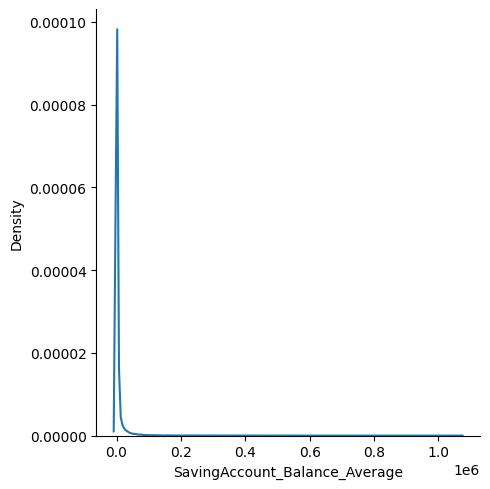

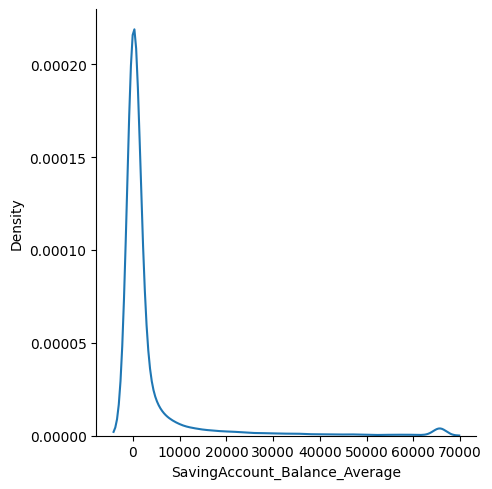

count    23191.000000
mean      3436.220177
std      10291.749729
min         -0.020000
25%          0.000000
50%         12.080000
75%       1505.200000
max      65664.583877
Name: SavingAccount_Balance_Average, dtype: float64

In [54]:
sns.displot(abt['SavingAccount_Balance_Average'], kind='kde')

three_sigma = 3 * abt['SavingAccount_Balance_Average'].std()
print('Three sigma ', three_sigma)

abt['SavingAccount_Balance_Average'] = np.where(abt['SavingAccount_Balance_Average'] > three_sigma, 
                                                          three_sigma,
                                                         abt['SavingAccount_Balance_Average'])


sns.displot(abt['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()
abt['SavingAccount_Balance_Average'].describe()

In [55]:
columns=Features
agg_colums=[x for x in abt.columns if x.endswith('_3m')]+[x for x in abt.columns if x.endswith('_6m')]
columns=columns+agg_colums
columns.remove('SavingAccount_Balance_Average')
for col in columns:
    three_sigma = 3 * abt[col].std()
    print(col)
    print(abt[col].describe())
    print('Three sigma ', three_sigma)
    abt[col] = np.where(abt[col] > three_sigma, 
                                                            three_sigma,
                                                            abt[col])
abt


CreditCard_Total_Limit
count     23191.000000
mean      49607.272218
std       59737.464407
min           0.000000
25%           0.000000
50%       40000.000000
75%       64000.000000
max      625000.000000
Name: CreditCard_Total_Limit, dtype: float64
Three sigma  179212.39322093304
CreditCard_Spending_Installments
count    23191.000000
mean      1776.586115
std       3185.093095
min          0.000000
25%          0.000000
50%         83.300000
75%       2484.655000
max      54774.050000
Name: CreditCard_Spending_Installments, dtype: float64
Three sigma  9555.279284632797
CreditCard_Spending_CrossBoarder
count    23191.000000
mean         8.498411
std         78.686432
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2570.400000
Name: CreditCard_Spending_CrossBoarder, dtype: float64
Three sigma  236.05929665507415
CreditCard_Revolving
count     23191.000000
mean       2143.647603
std        7910.096603
min      -84166.390000
25%         

,client_id,ProductAge_mean_6m,ProductAge_min_6m,ProductAge_max_6m,ProductAge_median_6m,ProductAge_sum_6m,ProductAge_var_6m,ProductAge_countnotzero_6m,ProductAge_diff_6m,SavingAccount_Percent_Credit_mean_6m,...,CreditCard_Revolving,CreditCard_Balance_ARG,CreditCard_Balance_DOLLAR,SavingAccount_Days_with_use,SavingAccount_CreditCard_Payment_Amount,SavingAccount_DebitCard_Spend_Transactions,SavingAccount_Transactions_Transactions,SavingAccount_Credits_Amounts,SavingAccount_Debits_Amounts,Region
0,5856970,1819.5,1743.0,1896.0,1819.5,10917.0,3265.1,0.812579,31.0,0.499741,...,0.00000,12606.510000,0.00,4.0,12606.51,1.0,8.0,153675.820000,153702.16000,AMBA Resto
1,6371753,1175.5,1099.0,1252.0,1175.5,7053.0,3265.1,0.812579,30.0,0.498919,...,0.00000,0.000000,0.00,5.0,0.00,0.0,6.0,3783.780000,3982.63000,REGION CENTRO
2,5928737,776.5,700.0,853.0,776.5,4659.0,3265.1,0.812579,-122.0,0.000000,...,0.00000,0.000000,0.00,0.0,0.00,0.0,0.0,0.000000,0.00000,REGION NORTE GRANDE ARGENTINO
3,475064,1556.5,1480.0,1633.0,1556.5,9339.0,3265.1,0.812579,-61.0,0.508803,...,0.00000,2646.130000,0.00,3.0,2585.28,0.0,4.0,2700.090000,2585.28000,REGION CUYO
4,3615172,293.5,217.0,370.0,293.5,1761.0,3265.1,0.812579,61.0,0.000000,...,0.00000,0.000000,0.00,0.0,0.00,0.0,0.0,0.000000,0.00000,REGION CENTRO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,1889189,790.5,714.0,867.0,790.5,4743.0,3265.1,0.812579,30.0,0.567800,...,23730.28981,38030.780817,0.00,2.0,11701.10,0.0,8.0,12000.000000,12001.10000,AMBA Resto
23187,6079919,1525.5,1449.0,1602.0,1525.5,9153.0,3265.1,0.812579,-92.0,0.416425,...,-1789.64000,2185.740000,0.00,1.0,6869.20,0.0,3.0,6869.200000,6869.20000,BUENOS AIRES
23188,6177294,1437.5,1361.0,1514.0,1437.5,8625.0,3265.1,0.812579,-92.0,0.000000,...,23730.28981,38030.780817,0.00,0.0,0.00,0.0,0.0,0.000000,0.00000,CABA Centro/Norte
23189,4038384,2805.5,2729.0,2882.0,2805.5,16833.0,3265.1,0.812579,-31.0,0.500190,...,0.00000,10279.700000,-53.41,12.0,10279.70,10.0,29.0,313364.989804,311467.11042,REGION NORTE GRANDE ARGENTINO


##### One Hot Encoding Region y CreditCard_Product


In [56]:
categorical_columns=['Region','CreditCard_Product','Client_Age_grp']
for col in categorical_columns:
    abt[col]=abt[col].astype('category')
    tmp=abt[[col]].drop_duplicates().sort_values(by=col,ascending=True)
    tmp_onehot=pd.get_dummies(tmp,dummy_na=False)
    
    df_encoded = pd.concat([tmp, tmp_onehot], axis=1)
    df_encoded
    abt=abt.merge(df_encoded,how='left',on=col)
abt.drop(columns=categorical_columns,inplace=True)
abt


,client_id,ProductAge_mean_6m,ProductAge_min_6m,ProductAge_max_6m,ProductAge_median_6m,ProductAge_sum_6m,ProductAge_var_6m,ProductAge_countnotzero_6m,ProductAge_diff_6m,SavingAccount_Percent_Credit_mean_6m,...,CreditCard_Product_J55661002XX012,CreditCard_Product_NA,CreditCard_Product_SD,Client_Age_grp_Entre 18 y 29 años,Client_Age_grp_Entre 30 y 39 años,Client_Age_grp_Entre 40 y 49 años,Client_Age_grp_Entre 50 y 59 años,Client_Age_grp_Entre 60 y 64 años,Client_Age_grp_Entre 65 y 69 años,Client_Age_grp_Mayor a 70 años
0,5856970,1819.5,1743.0,1896.0,1819.5,10917.0,3265.1,0.812579,31.0,0.499741,...,False,True,False,False,False,False,False,False,False,True
1,6371753,1175.5,1099.0,1252.0,1175.5,7053.0,3265.1,0.812579,30.0,0.498919,...,False,False,True,False,False,False,True,False,False,False
2,5928737,776.5,700.0,853.0,776.5,4659.0,3265.1,0.812579,-122.0,0.000000,...,False,False,True,False,True,False,False,False,False,False
3,475064,1556.5,1480.0,1633.0,1556.5,9339.0,3265.1,0.812579,-61.0,0.508803,...,False,True,False,False,False,False,False,False,False,True
4,3615172,293.5,217.0,370.0,293.5,1761.0,3265.1,0.812579,61.0,0.000000,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,1889189,790.5,714.0,867.0,790.5,4743.0,3265.1,0.812579,30.0,0.567800,...,False,True,False,False,True,False,False,False,False,False
23187,6079919,1525.5,1449.0,1602.0,1525.5,9153.0,3265.1,0.812579,-92.0,0.416425,...,False,True,False,False,True,False,False,False,False,False
23188,6177294,1437.5,1361.0,1514.0,1437.5,8625.0,3265.1,0.812579,-92.0,0.000000,...,False,True,False,False,False,False,True,False,False,False
23189,4038384,2805.5,2729.0,2882.0,2805.5,16833.0,3265.1,0.812579,-31.0,0.500190,...,False,True,False,False,False,True,False,False,False,False
